In [8]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaPhi
import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
a= tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2



# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [9]:
fpath =OrderedDict()
tree = OrderedDict()

data_year = 'full'
lumi = {'MC_Summer16':35.9*1000,
        'MC_Fall17': 41.5*1000, 
        'MC_Fall18':  59.7*1000 ,
       
       }


path = '/storage/af/group/phys_exotica/delayedjets/HNL/skim/'



# fpath['data'] = path+ 'EGamma_2018A.root'
fpath['data'] = '/storage/af/group/phys_exotica/delayedjets/HNL/displacedJetMuonAnalyzer/V1p17/Data2018/v5/v2/normalized/2018B.root'

fpath['wjets'] = path+ 'WJetsToLNu_1pb_weighted.root'
sample = ['HNL_electronType_mHNL10p0_pl10000',
    'HNL_electronType_mHNL10p0_pl1000',
    'HNL_electronType_mHNL10p0_pl100',
    'HNL_electronType_mHNL1p0_pl1000',
    'HNL_electronType_mHNL1p0_pl100',
    'HNL_electronType_mHNL1p0_pl10',
    'HNL_electronType_mHNL2p0_pl1000',
    'HNL_electronType_mHNL2p0_pl100',
    'HNL_electronType_mHNL2p0_pl10',
    'HNL_electronType_mHNL4p0_pl1000',
    'HNL_electronType_mHNL4p0_pl100',
    'HNL_electronType_mHNL4p0_pl10',
    'HNL_electronType_mHNL7p0_pl10000',
    'HNL_electronType_mHNL7p0_pl1000',
    'HNL_electronType_mHNL7p0_pl100',
        ]

for s in sample:
    fpath[s] = path + s + '_1pb_weighted.root'
NEvents = {}
Total = {}
accep = {}
accep_met = {}
for k,v in fpath.items():
#     print (k, v)
    root_dir = uproot.open(v) 
#     if not b'MuonSystem;1' in root_dir.keys():print("ERROR")
#     else:
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    
#     print("NEvents",NEvents[k],np.sum(a),len(a), a[0]*137000,)
    print(k,'\t', np.mean(tree[k]["gLLP_ctau"].array()[:,0]))


data 	 0.0
wjets 	 nan
HNL_electronType_mHNL10p0_pl10000 	 995.9101
HNL_electronType_mHNL10p0_pl1000 	 99.71724
HNL_electronType_mHNL10p0_pl100 	 10.025823
HNL_electronType_mHNL1p0_pl1000 	 nan
HNL_electronType_mHNL1p0_pl100 	 nan
HNL_electronType_mHNL1p0_pl10 	 nan
HNL_electronType_mHNL2p0_pl1000 	 99.71041
HNL_electronType_mHNL2p0_pl100 	 9.959987
HNL_electronType_mHNL2p0_pl10 	 1.0163016
HNL_electronType_mHNL4p0_pl1000 	 99.74496
HNL_electronType_mHNL4p0_pl100 	 9.999355
HNL_electronType_mHNL4p0_pl10 	 1.0537044
HNL_electronType_mHNL7p0_pl10000 	 996.96484
HNL_electronType_mHNL7p0_pl1000 	 99.30015
HNL_electronType_mHNL7p0_pl100 	 10.014029


# ndt with different hit vetoing

In [10]:

sel_ev = {}
metPhi = {}
dphiMetXYCorr_cluster = {}
evtNum = {}
dtRechitCluster_match_RPCBx_dPhi0p5_mode = {}
dtRechitClusterPhi = {}
dtRechitClusterNStation10 = {}
dtRechitClusterEta = {}
dtRechitClusterPhi = {}
dtRechitClusterAvgStation10 = {}
dtRechitClusterMaxStation = {}
dphiMet_cluster = {}
dtRechitCluster_match_RPCBx_dR0p4_mode = {}
dtClusterSize = {}
dtRechitCluster_match_gParticle_Pt = {}
dtRechitCluster_match_gParticle_Id = {}
dtRechitClusterMuonVetoPt = {}
dtRechitCluster_match_MB1hits_0p5 = {}
dphiLep_cluster = {}
# keys = ['inverted_mb1', 'inverted_jet_id','oot','signal']
keys = ['oot', 'signal','inverted_mb1']
for k in keys:
    T = tree['data']

        
########### SELECTION: CLUSTERS ############

    sel_rechitcluster = np.logical_and( T.array('dtRechitClusterMuonVetoPt') < 10, T.array('dtRechitClusterJetVetoPt') < 20)

    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_RPChits_dPhi0p5') > 0)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_MB1hits_cosmics_minus') <= 8)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_MB1hits_cosmics_plus') <= 8)

    if 'inverted_mb1' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_MB1hits_0p5') > 1)
    else:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_MB1hits_0p5') <= 1)

    if 'oot' in k:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_RPCBx_dPhi0p5')<0)
    else:
        sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('dtRechitCluster_match_RPCBx_dPhi0p5')==0)
########### = SELECTION: LEPTON ############
    
    sel_ele = np.logical_and(T.array('lepPt') > 35, np.abs(T.array('lepEta'))<2.4)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPdgId')) == 11)
    sel_ele = np.logical_and(sel_ele, np.abs(T.array('lepPassId')) == 1)
########### SELECTION: EVENTS ############
    # select only triggered events
    sel_ev[k] = T.array('SingleEleTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,sel_ele.sum()==1)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise')>=30)
    
    sel_ev[k]  = np.logical_and(sel_ev[k],sel_rechitcluster.sum() >= 1)
    
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtStations25')<3)
#     sel_ev[k] = np.logical_and(sel_ev[k],T.array('nDtWheels25')<3)
#     sel_ev[k] = np.logical_and(sel_ev[k],np.abs(T.array('jetMet_dPhiMin'))>0.6)
#     if 'HNL' in k: sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('gLLP_dt')[:,0])

    

########### BRANCHES ############
    print(k,np.count_nonzero(sel_ev[k]))
   ##### event variables ##### 

        
    dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitClusterNStation10[k] = T.array('dtRechitClusterNStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitClusterAvgStation10[k] = T.array('dtRechitClusterAvgStation10')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dphiMet_cluster[k] = T.array('dtRechitClusterMetEENoise_dPhi')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtClusterSize[k] =  T.array('dtRechitClusterSize')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    dtRechitCluster_match_RPCBx_dPhi0p5_mode[k] =  T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
    metPhi[k]  = T.array('metPhiEENoise')[sel_ev[k]]
    evtNum[k] = T.array('evtNum')[sel_ev[k]]
    
    dphiLep_cluster[k] = deltaPhi(T.array('lepPhi')[sel_ele][sel_ev[k]][:,0], dtRechitClusterPhi[k])


    
#     dtRechitCluster_match_gParticle_Id[k] = T.array('dtRechitCluster_match_gParticle_Id')[sel_rechitcluster][sel_ev[k]][:,0].flatten()
#     dtRechitCluster_match_gParticle_Pt[k] = T.array('dtRechitCluster_match_gParticle_Pt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()


#     dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_rechitcluster][sel_ev[k]][:,0].flatten()

    dtRechitCluster_match_MB1hits_0p5[k] = T.array('dtRechitCluster_match_MB1hits_0p5')[sel_rechitcluster][sel_ev[k]][:,0].flatten()





oot 8677
signal 37622
inverted_mb1 36533


# 2D distribution of dphi and Nrechits

0.002155780792236328


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


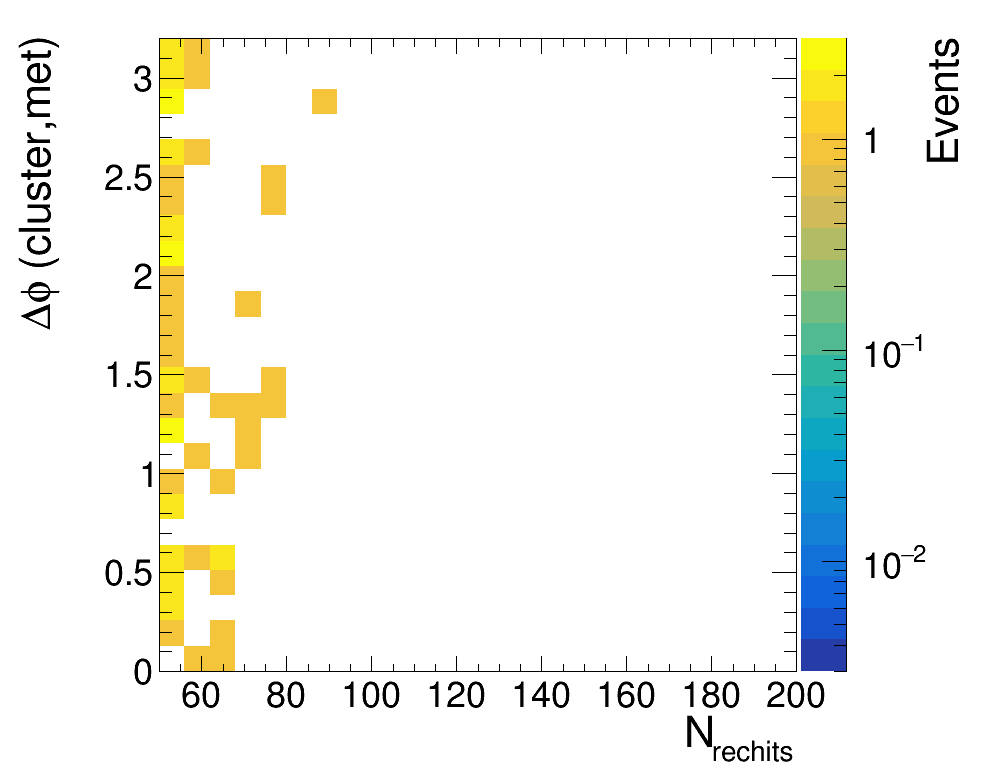

In [120]:
# Plotting ndt
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)

for k in dphiMet_cluster.keys():
    if not 'oot' in k:continue

    h = create_TH2D(np.column_stack(( dtClusterSize[k], np.abs(dphiMet_cluster[k]))),
                   axis_title = ['N_{rechits}','#Delta#phi (cluster,met)','Events'], binning=[25,50,200,25,0,3.2])
    h.Draw('colz')
    c.SetRightMargin(0.2)
    c.SetLogz()
    c.Draw()
print(time.time()-start_t)

# ABCD (Scan Nrechits)

In [5]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(50,106,1)
cuts = np.arange(60,220,10)
# cuts =[100]
# cuts = np.arange(90,150,1)
n_ev = 5000

##### A|B
##### C|D(SR)
# cuts = [90,95,100,104,105]
print(cuts)
bkg_dphiJet = []
sig_dphiJet = []
bkg_dphiCluster = []
sig_dphiCluster = []
# cuts = np.arange(130,150,5)
for N_RECHIT_CUT in cuts:
    for k in keys:
#         if not 'mb1' in k : continue
        if not 'oot' in k:continue
        cond = dtRechitClusterMaxStation[k] > 0
        if not 'inverted_mb1' in k:cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
        if 'signal' in k: 
            cond = np.logical_and(cond, dtClusterSize[k]<100)
            cond = np.logical_and(cond, np.abs(dphiLep_cluster[k])<2) #inverted dPhi(lep, cluster)
            cond = np.logical_and(cond, dtRechitCluster_match_RPCBx_dPhi0p5_mode[k]== 0)

    

        var = np.abs(dphiMet_cluster[k][cond])
        DPHI_CUT = 1.0
        a[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]<N_RECHIT_CUT, var>=DPHI_CUT))
        b[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]>=N_RECHIT_CUT, var>=DPHI_CUT))
        c[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]<N_RECHIT_CUT, var<DPHI_CUT))
        d[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]>=N_RECHIT_CUT, var<DPHI_CUT))
        
        
        pred = c[k]*b[k]/a[k]
        if a[k]==0 or b[k] == 0 or c[k] == 0:
            print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              0.0, '\t', 0.0)
        else:
            unc_pred = (1./c[k] + 1./b[k] + 1./a[k])**0.5*(pred)
            if math.isnan(unc_pred): z_value = float("nan")
            else:
                mu = np.random.normal(pred, unc_pred, n_ev)
                p_value = 0.0
                for i in mu:
                    if i < 0:continue
                    n = np.random.poisson(i, n_ev)
                    p_value += np.count_nonzero(n>=d[k])

                p_value = p_value/n_ev**2
                z_value = abs(norm.ppf(p_value))
            print(N_RECHIT_CUT, '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
                  round( (1./c[k] + 1./b[k] + 1./a[k])**0.5*(pred), 2), '\t', round(z_value,2))



[ 60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210]
60 	 107 	 72 	 53 	 33 	 35.66 	 7.32 	 0.29
70 	 149 	 30 	 69 	 17 	 13.89 	 3.24 	 0.55
80 	 165 	 14 	 81 	 5 	 6.87 	 2.06 	 0.67
90 	 174 	 5 	 84 	 2 	 2.41 	 1.13 	 0.34
100 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
110 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
120 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
130 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
140 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
150 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
160 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
170 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
180 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
190 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
200 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0
210 	 179 	 0 	 86 	 0 	 0.0 	 0.0 	 0.0


# ABCD (Scan dPhi)

In [7]:
a = {}
b = {}
c = {}
d = {}
cuts = np.arange(0.4, 2.1, 0.1)

print(cuts)
N_RECHIT_CUT = 80

n_ev = 5000

##### A|B
##### C|D(SR)

# cuts = np.arange(130,150,5)
for DPHI_CUT in cuts:
    for k in keys:
        if not 'oot' in k:continue
        cond = dtRechitClusterMaxStation[k] > 0
        cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
        if 'signal' in k: 
            cond = np.logical_and(cond, np.abs(dphiLep_cluster[k])<2)#inverted dPhi(lep, cluster)

        var = np.abs(dphiMet_cluster[k][cond])

        a[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]<N_RECHIT_CUT, var>=DPHI_CUT))
        b[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]>=N_RECHIT_CUT, var>=DPHI_CUT))
        c[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]<N_RECHIT_CUT, var<DPHI_CUT))
        d[k] = np.count_nonzero(np.logical_and(dtClusterSize[k][cond]>=N_RECHIT_CUT, var<DPHI_CUT))
        pred = c[k]*b[k]/a[k]
        if a[k]==0 or b[k] == 0 or c[k] == 0:
            print(round(DPHI_CUT,1), '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
              0.0, '\t', 0.0)
        else:
            unc_pred = (1./c[k] + 1./b[k] + 1./a[k])**0.5*(pred)
            if math.isnan(unc_pred): z_value = float("nan")
            else:
                mu = np.random.normal(pred, unc_pred, n_ev)
                p_value = 0.0
                for i in mu:
                    if i < 0:continue
                    n = np.random.poisson(i, n_ev)
                    p_value += np.count_nonzero(n>=d[k])

                p_value = p_value/n_ev**2
                z_value = abs(norm.ppf(p_value))
            print(round(DPHI_CUT,1), '\t',a[k],'\t',b[k],'\t',c[k],'\t',d[k],'\t', round(pred, 2), '\t',\
                  round( (1./c[k] + 1./b[k] + 1./a[k])**0.5*(pred), 2), '\t', round(z_value,2))

[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
0.4 	 211 	 18 	 35 	 1 	 2.99 	 0.89 	 1.45
0.5 	 203 	 17 	 43 	 2 	 3.6 	 1.06 	 0.97
0.6 	 197 	 17 	 49 	 2 	 4.23 	 1.23 	 1.21
0.7 	 189 	 16 	 57 	 3 	 4.83 	 1.41 	 0.86
0.8 	 182 	 15 	 64 	 4 	 5.27 	 1.56 	 0.58
0.9 	 172 	 14 	 74 	 5 	 6.02 	 1.81 	 0.42
1.0 	 165 	 14 	 81 	 5 	 6.87 	 2.06 	 0.64
1.1 	 161 	 13 	 85 	 6 	 6.86 	 2.11 	 0.33
1.2 	 152 	 12 	 94 	 7 	 7.42 	 2.35 	 0.16
1.3 	 146 	 12 	 100 	 7 	 8.22 	 2.6 	 0.36
1.4 	 141 	 12 	 105 	 7 	 8.94 	 2.83 	 0.53
1.5 	 131 	 11 	 115 	 8 	 9.66 	 3.16 	 0.44
1.6 	 123 	 11 	 123 	 8 	 11.0 	 3.6 	 0.69
1.7 	 110 	 11 	 136 	 8 	 13.6 	 4.46 	 1.08
1.8 	 97 	 11 	 149 	 8 	 16.9 	 5.55 	 1.41
1.9 	 87 	 10 	 159 	 9 	 18.28 	 6.27 	 1.32
2.0 	 81 	 10 	 165 	 9 	 20.37 	 7.01 	 1.51


## Distribution for variables in different Nrechit bins

15
 FCN=6.46866e-30 FROM MIGRAD    STATUS=CONVERGED      28 CALLS          29 TOTAL
                     EDM=2.52669e-21    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.42175e+00   2.77273e+00   0.00000e+00   3.81489e-10
   2  Slope       -5.54518e-02   4.56767e-02  -0.00000e+00   2.34973e-08


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


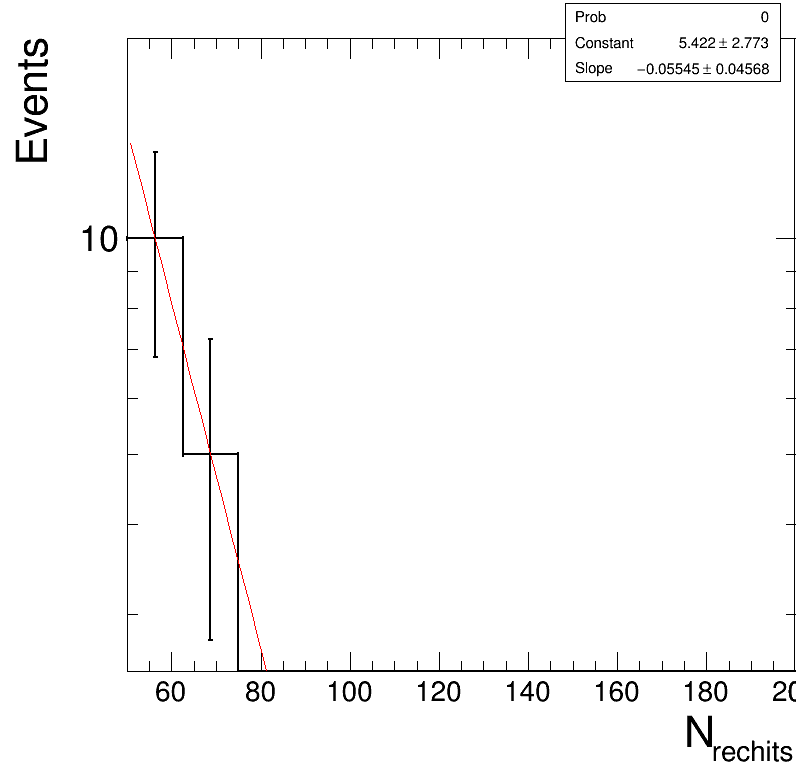

In [143]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot


# Plotting ndt
start_t = time.time()


br = 1
k = 'signal'
time_cut = 0
name = 'N_{rechits}'
# cuts = [50, 60,80, 2000]
cuts = [50,2000]
# cuts = [50,2000]

var = [dtRechitClusterPhi, metPhi, dphiMet_cluster, dtClusterSize, dtRechitClusterMaxStation]
varName = ['dtRechitClusterPhi', 'metPhi', 'dphiMet_cluster', 'dtClusterSize','dtRechitClusterMaxStation']
xaxis = ['cluster #phi', 'MET #phi', '#Delta #phi(cluster,met)', 'N_{rechits}','max station']
bins = [[15,-3.2,3.2], [15,-3.2,3.2], [15,0,3.2],[12,50,200],[5,0,5]]


for j,v in enumerate(var):
    if not j ==3:continue
    for l in range(len(cat)):
        if not l == 0:continue
        leg = rt.TLegend(0.6,0.77,0.90,0.92)

        leg.SetTextSize(0.03)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)
        c = rt.TCanvas('c','c', 800, 800)

        h = {}
        rt.gStyle.SetOptFit(1011)
        maxb = 0
        for i,cut in enumerate(cuts):
            
            metcut = 200
            if i == 0:
                previous_cut = cut

                continue
                cond = dtClusterSize[k] <= cut
            else:
                cond = np.logical_and(dtClusterSize[k] < cut, dtClusterSize[k] >= previous_cut)
            cond = np.logical_and(cond, cat[l])
            if 'signal' in k: 
                cond = np.logical_and(cond, np.abs(dphiLep_cluster[k])<2)
#                 cond = np.logical_and(cond, dtRechitCluster_match_RPCBx_dPhi0p5_mode[k]== 0)

            if 'oot' in k:
                cond = np.logical_and(cond, np.abs(dphiLep_cluster[k])>=1)

            if not 'inverted_mb1' in k:cond = np.logical_and(cond, dtRechitCluster_match_MB1hits_0p5[k]<=1)
            cond = np.logical_and(cond, np.abs(dphiMet_cluster[k])<1)
            cond = np.logical_and(cond, dtClusterSize[k]<=100)




            h[str(i)] = create_TH1D( np.abs(v[k][cond]), axis_title=[xaxis[j], 'Events'], name=k, binning=bins[j])
            print(np.count_nonzero(cond))
            leg.AddEntry(h[str(i)], name+" [%(first)d,%(second)d)"%{"first":previous_cut,"second":cut})

            previous_cut = cut

            
            
            h[str(i)].Fit('expo', "","",50,200)
    #         h[str(i)].SetMinimum(100)

#             if h[str(i)].Integral()>0:h[str(i)].Scale(1/h[str(i)].Integral())
#             h[str(i)].SetMaximum(5)
#             h[str(i)].SetMinimum(0.001)
            h[str(i)].GetXaxis().SetLabelSize(0.04)
            h[str(i)].SetLineColor(std_color_list[i-1])
            h[str(i)].Draw('same E1')


        c.SetRightMargin(0)
        c.SetLogy()
#         leg.Draw()
        c.Draw()
